<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />


<h1>Preprocessing with Principle Component Analysis </h1>

<h2>Table of Contents</h2>
<p>This notebook contains neural networks trained to predict house prices in King County, Washington, USA based on features of the house. They are trained using different preprocessing methods like PCA and Standardization. They are also trained using different Neural Networks with one featuring batch normalization. We will explore the benefits of data preprocessing on our neural networks and how they affect performance.</p>

<ul>
    <li><a href="#UFI">Utility Functions and Imports </a></li>
    <li><a href="#MDC">Dataset Class   </a></li>
    <li><a href="#DNN"> Different Neural Networks and Function to Train Neural Network   </a></li>
    <li><a href="#tv">Training and Validate Model </a></li>
</ul>

<p>Estimated Time Needed: <strong>20 min</strong></p>

<hr>


<h2 id="UFI">Utility Functions and Imports </h2>

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn import preprocessing
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
torch.manual_seed(1)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing th

Here we load the dataset we will use and the already trained models to save time instead of training from scratch.

In [2]:
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/king_county_house_data.csv
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/pca_model.pt
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/regular_model.pt
!wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/standardized_model.pt

--2024-02-10 00:11:31--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/king_county_house_data.csv
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104, 169.63.118.104
Connecting to s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1930704 (1.8M) [text/csv]
Saving to: ‘king_county_house_data.csv.1’

king_county_house_d 100%[===================>]   1.84M  --.-KB/s    in 0.04s   

2024-02-10 00:11:31 (47.2 MB/s) - ‘king_county_house_data.csv.1’ saved [1930704/1930704]

--2024-02-10 00:11:32--  https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/meet_up/12.02.2020/pca_model.pt
Resolving s3.us.cloud-object-storage.appdomain.cloud (s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104, 169.63.118.104
Connecting to

<h2 id="DSC">Dataset Class </h2>

Turn the csv into a dataframe

In [3]:
df = pd.read_csv('king_county_house_data.csv')
print(df.shape)
df.head()

(21613, 19)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Create a PyTorch Dataset object to store our dataframe values in. We create 3 type of data one for data with PCA, Standardization, and regular data with no preprocessing.

In [4]:
class data(Dataset):
    
    def __init__(self, test=False, regular=False, pca=False, standard=False):
        
        X = df.drop(columns='price')
        Y = df['price']
        # Split the data into training data and testing data using a 80/20 split
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=1)
        
        x_train = x_train.astype(float)
        x_test = x_test.astype(float)
        
        if (regular):
            
            if (test):
                self.x = torch.FloatTensor(x_test.values)
                self.y = torch.FloatTensor(y_test.values).view(-1,1)
            else:
                self.x = torch.FloatTensor(x_train.values)
                self.y = torch.FloatTensor(y_train.values).view(-1,1)
                
        elif (pca):
            
            # Performs PCA on the data
            pca = PCA(whiten=True)
            x_train = pca.fit_transform(x_train)
            x_test = pca.transform(x_test)
            
            if (test):
                self.x = torch.FloatTensor(x_test)
                self.y = torch.FloatTensor(y_test.values).view(-1,1)
            else:
                self.x = torch.FloatTensor(x_train)
                self.y = torch.FloatTensor(y_train.values).view(-1,1)
                
        else:
            
            # Performs Standardization on the data
            standard = preprocessing.StandardScaler()
            x_train = standard.fit_transform(x_train)
            x_test = standard.transform(x_test)
            
            if (test):
                self.x = torch.FloatTensor(x_test)
                self.y = torch.FloatTensor(y_test.values).view(-1,1)
            else:
                self.x = torch.FloatTensor(x_train)
                self.y = torch.FloatTensor(y_train.values).view(-1,1)

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

<h2 id="DNN">Different Neural Networks and Function to Train Neural Network    </h2>

Here we define the Neural Networks we will use. They are both 4 layered networks with 1 input layer, 1 output layer, and 2 hidden layers. THe number of nodes in each layer is 2/3 of the input layer except the output because we are doing regression. They both use relu as the activation function.

The difference is that one uses Batch Normalization and one does not.

In [5]:
class BatchNormalizationNN(nn.Module):
    
    # Constructor
    def __init__(self):
        super(BatchNormalizationNN, self).__init__()
        # The dataset has 18 features
        self.linear1 = nn.Linear(18, 12)
        self.b1 = nn.BatchNorm1d(12)
        self.linear2 = nn.Linear(12, 8)
        self.b2 = nn.BatchNorm1d(8)
        self.linear3 = nn.Linear(8, 1)

    # Prediction    
    def forward(self, x): 
        y = self.b1(torch.relu(self.linear1(x)))
        y = self.b2(torch.relu(self.linear2(y)))
        y = self.linear3(y)
        return y

In [6]:
class RegularNN(nn.Module):
    
    # Constructor
    def __init__(self):
        super(RegularNN, self).__init__()
        # The dataset has 18 features
        self.linear1 = nn.Linear(18, 12)
        self.linear2 = nn.Linear(12, 8)
        self.linear3 = nn.Linear(8, 1)

    # Prediction    
    def forward(self, x): 
        y = torch.relu(self.linear1(x)) 
        y = torch.relu(self.linear2(y))
        y = self.linear3(y)
        return y

Function performs the training of the models. It is given the training data, testing data, criterion (loss function), model(Neural Network), optimizer, and epochs (Number of times the model is trained on the entire dataset). 

In [7]:
def train(train_loader, test_loader, criterion, model, optimizer, epochs):
    
    train_loss = []
    test_loss = []
    
    for epoch in range(epochs):
        
        print(epoch)
        
        total_loss = 0
        
        for i, (x, y) in enumerate(train_loader):
            # Set the model in training mode so it updates values in Batch Normalization
            model.train()
            # Clears the optimizer
            optimizer.zero_grad()
            # Calculates the prediction the model gives
            z = model(x)
            # Calculates the loss between the prediction and the actual value
            loss = criterion(z, y)
            # Calcualates the partial deriviative for each parameter of the Neural Network
            loss.backward()
            # Adjusts the parameters according to the optimizer
            optimizer.step()
            total_loss = total_loss + loss.item()
        
        train_loss.append(total_loss/(len(train_loader.dataset)/train_loader.batch_size))
        print(total_loss/(len(train_loader.dataset)/train_loader.batch_size))
        
        total_loss = 0
        
        for i, (x, y) in enumerate(test_loader):
            # Set the model in evaluation mode so we do not train the Batch Normalization while evaluating our model
            model.eval()
            z = model(x)
            loss = criterion(z, y)
            total_loss = total_loss + loss.item()
           
        test_loss.append(total_loss/len(test_loader.dataset))
        print(total_loss/len(test_loader.dataset))
        
    return train_loss, test_loss

<h2 id="UFI">Training and Validate Model  </h2>

We have trained the model prior you can load them and use them to run you model.

Vanilla Neural network 

In [8]:
RegularModel = RegularNN()
checkpoint = torch.load('regular_model.pt')
RegularModel.load_state_dict(checkpoint['model_state_dict'])
RegularModel.eval()
regular_train_loss = checkpoint['train_loss']
regular_test_loss = checkpoint['test_loss']

Neural network with Batch Norm  

In [9]:
PCAModel = BatchNormalizationNN()
checkpoint = torch.load('pca_model.pt')
PCAModel.load_state_dict(checkpoint['model_state_dict'])
PCAModel.eval()
pca_train_loss = checkpoint['train_loss']
pca_test_loss = checkpoint['test_loss']

Neural network with Batch Norm  and Starderdizing the data :

In [10]:
StandardModel = BatchNormalizationNN()
checkpoint = torch.load('standardized_model.pt')
StandardModel.load_state_dict(checkpoint['model_state_dict'])
StandardModel.eval()
stan_train_loss = checkpoint['train_loss']
stan_test_loss = checkpoint['test_loss']

## Training

The code in the sections below is code to train the models with each type of preprocessing. The training code is saved a raw so it does not accidentally get run as it would take a lot of time to train. The loss function used is SmoothL1Loss and in its current setup it gives the absolute value of the error between the prediction and actual value. The optimizer used is Adadelta, we use this because we do not need to worry about initializing or updating the rate at which the Neural Network learns. If you would like to experiment with the Neural Networks please change the type of the training block to code using the options at the top. 

## Regular Neural Network       

If you would like to train the model yourself. you can convert the following markdown cell to a code.   

In [11]:
d_train = data(regular=True, test=False) 
train_loader = torch.utils.data.DataLoader(dataset=d_train, batch_size=500)
d_test = data(regular=True, test=True)
test_loader = torch.utils.data.DataLoader(dataset=d_test)
criterion = nn.SmoothL1Loss()
RegularModel = RegularNN()
optimizer = torch.optim.Adadelta(RegularModel.parameters())
regular_train_loss, regular_test_loss = train(train_loader, test_loader, criterion, RegularModel, optimizer, 10)

0
440361.35546197224
228389.0386016655
1
214756.96256868134
217870.31770471894
2
206672.23241396763
208479.27470795743
3
194702.93341526896
192779.41702810547
4
177716.8888266339
177360.15143563497
5
166632.06062030076
170724.5618602533
6
162829.15386422788
169078.74683379597
7
161268.500578369
167200.07010105829
8
160725.45591743782
166718.40557049503
9
160227.36634253906
166311.99363867685


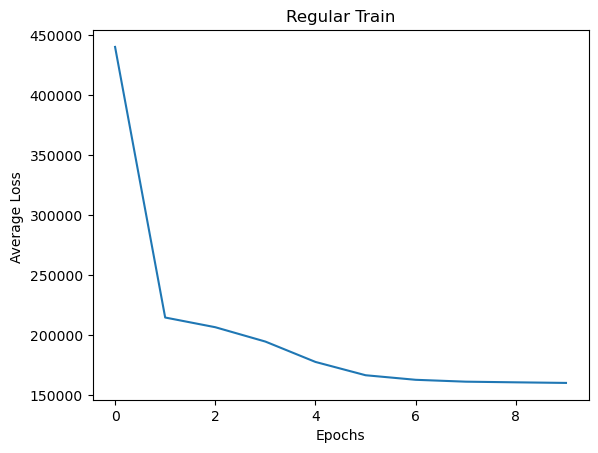

160227.36634253906


In [12]:
plt.plot(regular_train_loss)
plt.title("Regular Train")
plt.xlabel("Epochs")
plt.ylabel("Average Loss ")
plt.show()
print(regular_train_loss[-1])

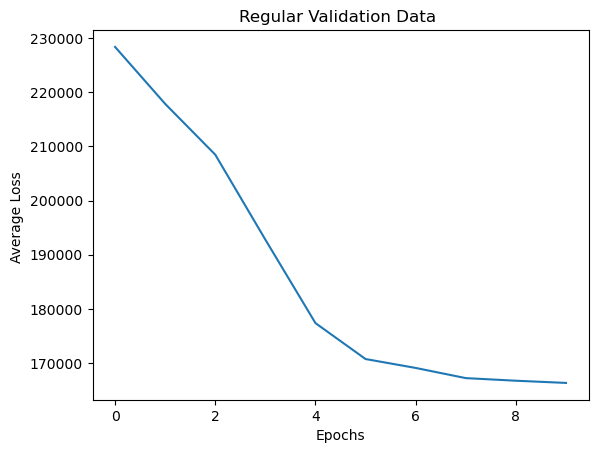

166311.99363867685


In [13]:
plt.plot(regular_test_loss)
plt.title("Regular Validation Data ")
plt.xlabel("Epochs")
plt.ylabel("Average Loss ")
plt.show()
print(regular_test_loss[-1])

In [14]:
torch.save({
    'epochs': 500,
    'model_state_dict': RegularModel.state_dict(),
    'train_loss': regular_train_loss,
    'test_loss': regular_test_loss
}, 'regular_model.pt')

## PCA and  Regular Neural Network  

In [15]:
d_train = data(pca=True, test=False) #PCA ACTIVATED
train_loader = torch.utils.data.DataLoader(dataset=d_train, batch_size=500)
d_test = data(pca=True, test=True)
test_loader = torch.utils.data.DataLoader(dataset=d_test)
criterion = nn.SmoothL1Loss()
PCAModel = BatchNormalizationNN()
optimizer = torch.optim.Adadelta(PCAModel.parameters())
pca_train_loss, pca_test_loss = train(train_loader, test_loader, criterion, PCAModel, optimizer, 60)

0
545066.0786581839
548915.1903535594
1
545053.0599334876
548870.4652440435
2
544812.6536292655
548176.792311835
3
542132.9137145749
541462.997495229
4
521397.5274725275
494829.4007723947
5
402860.3455754772
281255.6287661925
6
230485.98358877967
223456.37648189915
7
212002.45580899366
216172.9353313671
8
204026.628470214
206467.29199919038
9
194907.4831007808
196052.40137780475
10
184225.25891049742
185124.6817675804
11
171802.65868999422
170628.14251532502
12
157420.33034810584
156899.40256332408
13
141791.76117878832
140469.33363332754
14
126249.72324139677
124279.90403438006
15
112631.40204778775
113723.24546394286
16
102388.41635338347
110228.0343330731
17
95256.41673293812
101080.46460429678
18
90267.9359908184
96057.0201429852
19
86951.46264097745
95358.66087641683
20
84725.25800679583
93399.35356317679
21
83295.79462478311
92380.02007792621
22
82254.221641845
91340.30359776197
23
81535.89909268364
90505.68810159796
24
81001.33838201273
89258.77480193153
25
80558.40962080682
891

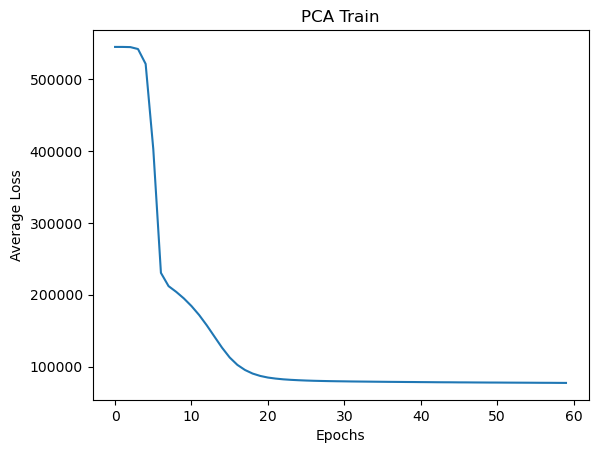

77244.62037756652


In [16]:
plt.plot(pca_train_loss)
plt.title("PCA Train")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()
print(pca_train_loss[-1])

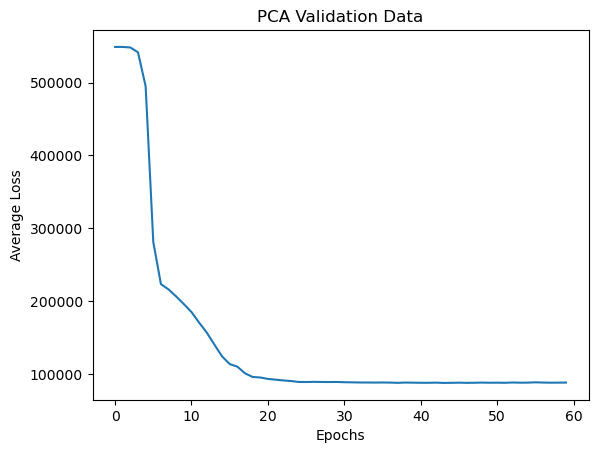

88394.00335415221


In [17]:
plt.plot(pca_test_loss)
plt.title("PCA Validation Data")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()
print(pca_test_loss[-1])

In [18]:
torch.save({
    'epochs': 60,
    'model_state_dict': PCAModel.state_dict(),
    'train_loss': pca_train_loss,
    'test_loss': pca_test_loss
}, 'pca_model.pt')

## Standardized Data and Neural Network     

In [19]:
_train = data(standard=True, test=False)
train_loader = torch.utils.data.DataLoader(dataset=d_train, batch_size=500)
d_test = data(standard=True, test=True)
test_loader = torch.utils.data.DataLoader(dataset=d_test)
criterion = nn.SmoothL1Loss()
StandardModel = BatchNormalizationNN()
optimizer = torch.optim.Adadelta(StandardModel.parameters())
stan_train_loss, stan_test_loss = train(train_loader, test_loader, criterion, StandardModel, optimizer, 20)

0
545065.9566584731
548913.7559709692
1
545025.3885916715
548753.6838295888
2
543986.7761350492
545555.5934572346
3
530445.114589358
510277.2688490342
4
418865.903340081
284121.8172637636
5
230532.27976792946
225673.256592644
6
216005.0123807114
222074.06906372888
7
211129.46021905728
217624.4752848138
8
205471.35040124352
212999.72782934306
9
198742.6962839792
207552.23990862825
10
190535.88915196646
200246.57309738608
11
180302.97995589938
192019.88049387
12
167617.89238721805
181892.8126228892
13
152405.38990203876
170619.14826943094
14
135548.25020785138
160850.77425977332
15
119909.29276315791
154049.21486814713
16
107180.58939415848
151322.64350566737
17
98029.88156991036
151711.90963306732
18
91641.72683812898
150389.35030650013
19
87944.34892820995
149776.17259787762


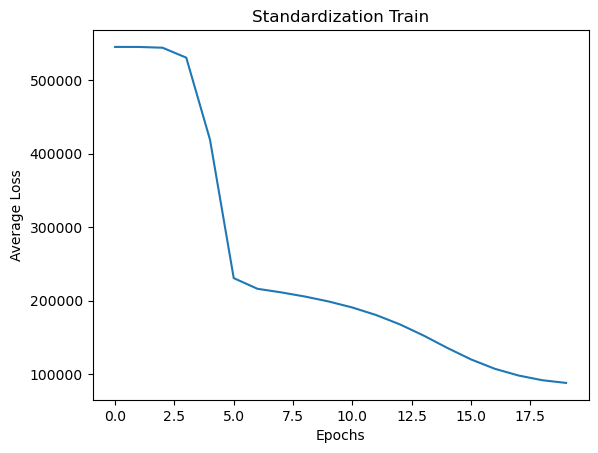

87944.34892820995


In [20]:
plt.plot(stan_train_loss)
plt.title("Standardization Train")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()
print(stan_train_loss[-1])

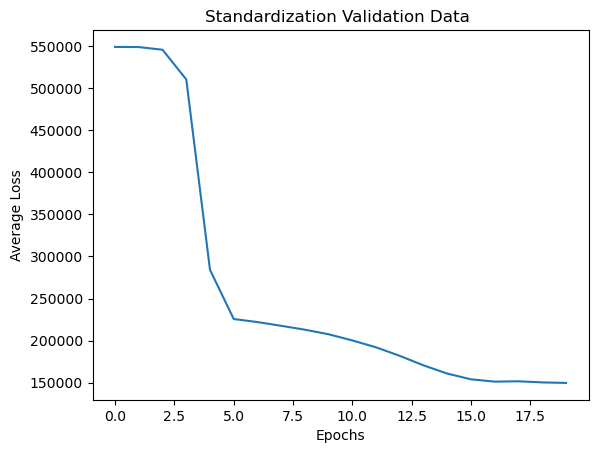

149776.17259787762


In [21]:
plt.plot(stan_test_loss)
plt.title("Standardization Validation Data ")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.show()
print(stan_test_loss[-1])

## Viewing the Results

The code below will allow you to see the predicted price, actual price, and error for each house in the test dataset.We will use the absolute Loss.

In [22]:
criterion = nn.SmoothL1Loss()
limit = 9

In [23]:
d_test = data(regular=True, test=True)
test_loader = torch.utils.data.DataLoader(dataset=d_test)

for i, (x, y) in enumerate(test_loader):
    RegularModel.eval()
    z = RegularModel(x)
    loss = criterion(z, y)
    print(i)
    print('Predicted: ',z.item())
    print('Actual: ', y.item())
    print('Loss: ', loss.item())
    if (i == limit):
        break

0
Predicted:  712981.0
Actual:  459000.0
Loss:  253980.5
1
Predicted:  405973.4375
Actual:  445000.0
Loss:  39026.0625
2
Predicted:  646139.0
Actual:  1057000.0
Loss:  410860.5
3
Predicted:  562974.9375
Actual:  732350.0
Loss:  169374.5625
4
Predicted:  349270.28125
Actual:  235000.0
Loss:  114269.78125
5
Predicted:  531688.1875
Actual:  555000.0
Loss:  23311.3125
6
Predicted:  664266.1875
Actual:  365000.0
Loss:  299265.6875
7
Predicted:  927529.0625
Actual:  685000.0
Loss:  242528.5625
8
Predicted:  407059.125
Actual:  525000.0
Loss:  117940.375
9
Predicted:  515306.40625
Actual:  449950.0
Loss:  65355.90625


In [24]:
d_test = data(pca=True, test=True)
test_loader = torch.utils.data.DataLoader(dataset=d_test)

for i, (x, y) in enumerate(test_loader):
    PCAModel.eval()
    z = PCAModel(x)
    loss = criterion(z, y)
    print(i)
    print('Predicted: ',z.item())
    print('Actual: ', y.item())
    print('Loss: ', loss.item())
    if (i == limit):
        break

0
Predicted:  475038.5625
Actual:  459000.0
Loss:  16038.0625
1
Predicted:  449764.4375
Actual:  445000.0
Loss:  4763.9375
2
Predicted:  598215.1875
Actual:  1057000.0
Loss:  458784.3125
3
Predicted:  771003.9375
Actual:  732350.0
Loss:  38653.4375
4
Predicted:  225825.859375
Actual:  235000.0
Loss:  9173.640625
5
Predicted:  666851.0
Actual:  555000.0
Loss:  111850.5
6
Predicted:  372953.4375
Actual:  365000.0
Loss:  7952.9375
7
Predicted:  688262.75
Actual:  685000.0
Loss:  3262.25
8
Predicted:  520498.59375
Actual:  525000.0
Loss:  4500.90625
9
Predicted:  486147.28125
Actual:  449950.0
Loss:  36196.78125


In [25]:
d_test = data(standard=True, test=True)
test_loader = torch.utils.data.DataLoader(dataset=d_test)

for i, (x, y) in enumerate(test_loader):
    StandardModel.eval()
    z = StandardModel(x)
    loss = criterion(z, y)
    print(i)
    print('Predicted: ',z.item())
    print('Actual: ', y.item())
    print('Loss: ', loss.item())
    if (i == limit):
        break

0
Predicted:  481212.09375
Actual:  459000.0
Loss:  22211.59375
1
Predicted:  415925.46875
Actual:  445000.0
Loss:  29074.03125
2
Predicted:  358657.59375
Actual:  1057000.0
Loss:  698341.875
3
Predicted:  657842.75
Actual:  732350.0
Loss:  74506.75
4
Predicted:  317061.96875
Actual:  235000.0
Loss:  82061.46875
5
Predicted:  576521.4375
Actual:  555000.0
Loss:  21520.9375
6
Predicted:  377249.75
Actual:  365000.0
Loss:  12249.25
7
Predicted:  785067.25
Actual:  685000.0
Loss:  100066.75
8
Predicted:  551115.0625
Actual:  525000.0
Loss:  26114.5625
9
Predicted:  477560.125
Actual:  449950.0
Loss:  27609.625


<h2>About the Authors:</h2> 
<p><a>Azim Hirjani</a></p>
<p><a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.</p>

Copyright &copy; 2020 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.